In [294]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#get all the files from your experiment
import glob

#deal with the .fcs file format
import fcsparser

## Use glob to get all the fcs files you want to deal with

In [295]:
path = '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min'

#get all the .fcs files in the directory (doesn't walk down directories to aggregate all further along dir tree)
allfcs = glob.glob(path + '/*.fcs')

In [296]:
allfcs[0:9]

['../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\bfp-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\bfpfinal-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\blank-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\blank10k-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\blankfinal-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\DI-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\preplateDI-RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\RDM2018-10-23.0001.fcs',
 '../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min\\RDM2018-10-23.0002.fcs']

In [297]:
#ugly nested list comprehension to get all the non control files

#using list comprehensionn to exclude files that have ctrl information in them
expfcs = [c for c in 
 [b for b in 
  [a for a in 
   [s for s in allfcs if 'bfp' not in s]
  if 'yfp' not in a]
 if 'DI' not in b]
if 'blank' not in c]

#nicer way to use previous list to get ctrls out of allfcs

ctrlfcs = [d for d in allfcs if d not in expfcs]

finalctrlfcs = [f for f in ctrlfcs if 'final' in f]

In [298]:
#I created an excel file that correlates fcs file number to well and volume flowed
ids = pd.read_excel('../Local Data/20181009 top 4 A B cell vars A=B flow samples/10min/fcs num to well ID.xlsx', dtype=str)

In [299]:
ids.head(11)

,fcs num,well,vol
0,0001,BAD,x
1,0002,A1,x
2,0003,B1,x
3,0004,C1,x
4,0005,D1,x
5,0006,E1,x
6,0007,BAD,x
7,0008,F1,35
8,0009,G1,35
9,0010,H1,35


In [300]:
#add the filename to the IDs dataframe so you can look for well and get filename for analysis

#get the index and the fcs file num as a tuple.
#I'm pretty sure if the index was noncontinuous, this would still associate correct index to fcs num entry
for idx, num in zip(ids['fcs num'].index, ids['fcs num']):
    

    #get the list of filenames that contain the fcs num you're looking for
    #this list should ideally be len = 1
    fname = [f for f in expfcs if num in f]
    
    #this list that will be added to the 'file' column is sometimes just a string, sometimes a list with one element
    #I want just the value inside the list
    if len(fname) == 1:
        add = fname[0]
    elif len(fname) == 0:
        add = 'NO MATCH'
    elif len(fname) > 1:
        add = '> 1 MATCH'
    
    
    ids.loc[idx, 'file'] = add



In [301]:
#if the value of this statement is TRUE, then there's a non-assignment or a multiple assignment of filenames
if any((ids['file'] == 'NO MATCH') | (ids['file'] == '> 1 MATCH')):
                            #gotta use bitwise OR, dunno why
    print("there's a non-assignment or a multiple assignment of filenames!!!")

## use fcsparser to unpack fcs file to dataframe

In [316]:
wellsIwant = ['C8', 'D8']

### *need to write a gating function here to gate on the mKate (syto) channel before throwing it to kdeplot*

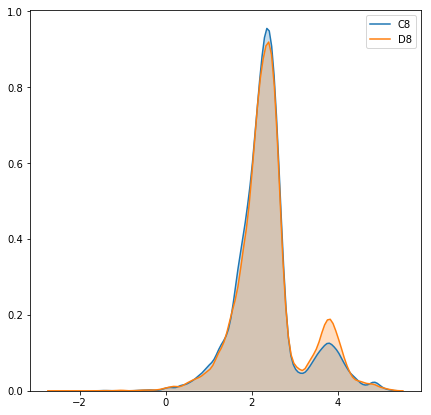

In [317]:
fig, ax = plt.subplots(figsize=(7, 7))

for well in wellsIwant:
    
    idx = ids['well'] == well
    
    #gotta get values, which is an array, hence the [0], to get the actual string inside the array
    #because fcsparser only takes string input, can't deal with dataframe slices or arrays
    path = ids.loc[idx, 'file'].values[0]
    
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    
    
    #THIS ISN'T FINAL, I WANT TO COLLECT THE VARIOUS DATAS TOGETHER IN SOME LIST OR SOMETHING
    #FOR NOW I'M JUST DOING THIS PLOTTING ALTOGETHER IN A LOOP TO GET PLOTS
    
    #some of the values are negative, get rid of that 
    for col in data.columns:
        data.loc[data[col] < 0, col] = np.nan
        
    sns.kdeplot(np.log10(data['GFP/FITC-A']), shade=True, ax=ax)
    ax.legend(wellsIwant)

In [270]:
data.head()

,HDR-T,FSC-A,SSC-A,CFP/VioBlue-A,PE-A,mKate/APC-A,GFP/FITC-A
0,29.066689,15446.903320,2339.543701,NaN,1.258434,1304.283325,76.542618
1,31.174990,NaN,3261.166016,NaN,NaN,706.489685,1694.591064
2,35.616379,25883.492188,2960.838135,168.417252,NaN,NaN,NaN
3,41.390961,NaN,2640.856934,NaN,73.938362,4331.254395,30.025940
4,82.285851,11814.180664,1910.152710,481.378021,88.105385,NaN,NaN


## Plots

### get something like what the MACSquant would show you

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set(xscale="log", yscale="log")

ax.set_xlim([10**-2, 10**6])
ax.set_ylim([1, 10**6])

ax.scatter(data['CFP/VioBlue-A'], data['SSC-A'], alpha=0.1, marker='o', s=1)

In [ ]:
#havent figured out how to get a color coded density plot yet without using seaborn kde plot which seems to hang
#and not generate anything

### Get histograms

In [ ]:
sns.kdeplot(np.log10(data['CFP/VioBlue-A']), shade=True)

#plt.xscale('log')

C:\Users\geeze\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


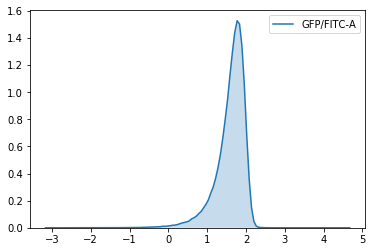

In [48]:
sns.kdeplot(np.log10(data['GFP/FITC-A']), shade=True)

#plt.xscale('log')